In [217]:
import sys
sys.path.append("../")
import os
import numpy as np
import nibabel as nb
import pandas as pd
import matplotlib.pylab as plt
import SimpleITK as sitk
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from data.nifti_dataset import resample_nifti
from data.base_dataset import _roll2center_crop
from scipy.ndimage.measurements import center_of_mass
from skimage.measure import label, regionprops

from utils import myocardial_strain_zc
from scipy.ndimage import gaussian_filter
import DeepStrain.functions_collection as ff
import DeepStrain.Data_processing as Data_processing

main_path = '/mnt/camca_NAS/Deepstrain'

patient_list = pd.read_excel(os.path.join('/mnt/camca_NAS/HFpEF/data/HFpEF_data/Patient_list', 'Important_HFpEF_Patient_list_unique_patient_w_ZCnotes.xlsx'))
patient_list = patient_list[patient_list['include?'] == 'yes']
patient_list = patient_list[patient_list['StudyDate']>20150219]
print(patient_list.shape)

(136, 30)


# Step 1: load a case (its segmentation and strain)

In [717]:
# find patinet_list
patient_index = 136

patient_id_num = patient_list['OurID'].iloc[patient_index]
patient_id = ff.XX_to_ID_00XX(patient_id_num)
print(patient_id)

# define the effective slices
effective_slices_list = []
for i in range(0,15):
    patient_seg_folder = os.path.join(main_path,'results/preprocessed_inputs',patient_id, 'seg')
    patient_seg = nb.load(os.path.join(patient_seg_folder, 'seg_tf' + str(i) + '.nii.gz')).get_fdata()
    effective_slice = []
    for j in range(patient_seg.shape[2]):
        if np.sum(patient_seg[:,:,j]==2)>0:
            effective_slice.append(j)
    effective_slices_list.append(effective_slice)

sets = [set(lst) for lst in effective_slices_list]
intersection = set.intersection(*sets)
effective_slices = list(intersection)
print(effective_slices)

# assert the first slice is 'basal'
a = patient_seg[:,:,effective_slices[3]]
b = patient_seg[:,:,effective_slices[10]]
assert np.sum(a>0) > np.sum(b>0)

IndexError: single positional indexer is out-of-bounds

ID_1027 0 6
y_t shape:  (1, 128, 128, 16, 3)
Global Radial strain:  10.920697994407389
Global Circumferential strain:  -10.038336125574961


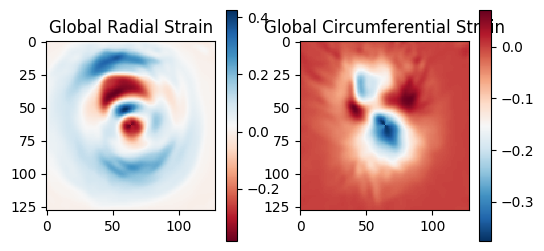

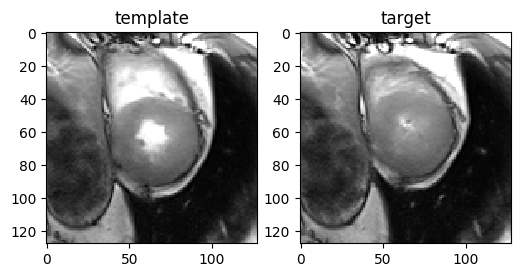

In [718]:
# first: get two frames
tf1 = 0
tf2 = 6
print(patient_id, tf1,tf2)


save_folder = os.path.join(main_path, 'results/strain/', patient_id)
ff.make_folder([save_folder])

# # second: load img and seg
patient_img_folder = os.path.join(main_path,'results/preprocessed_inputs',patient_id, 'img_cropped')
patient_seg_folder = os.path.join(main_path,'results/preprocessed_inputs',patient_id, 'seg_cropped')

V_nifti_1 = nb.load(os.path.join(patient_img_folder, 'img_tf' + str(tf1) + '.nii.gz'))
V_nifti_2 = nb.load(os.path.join(patient_img_folder, 'img_tf' + str(tf2) + '.nii.gz'))

M_nifti_1 = nb.load(os.path.join(patient_seg_folder, 'seg_tf' + str(tf1) + '.nii.gz'))
# M_nifti_2 = nb.load(os.path.join(patient_seg_folder ,'seg_tf' + str(tf2) + '.nii.gz'))

# fifth: get motion vector field
y_t = nb.load(os.path.join(main_path, 'results/MVF', patient_id, 'mvf_template'+str(tf1) + '_target'+str(tf2)+'.nii.gz')).get_fdata()
y_t = y_t[None,...]
print('y_t shape: ', y_t.shape)

# last: calculate strain |
mask_tf1 = M_nifti_1.get_fdata()
# mask_tf2 = M_nifti_2.get_fdata()

# # calculate strain
strain = myocardial_strain_zc.MyocardialStrain(mask=mask_tf1, flow=y_t[0,:,:,:,:])
strain.calculate_strain(lv_label=2)

global_radial_strain = strain.Err[strain.mask_rot==2].mean()
global_circumferential_strain = strain.Ecc[strain.mask_rot==2].mean()
print('Global Radial strain: ', global_radial_strain*100) 
print('Global Circumferential strain: ', global_circumferential_strain*100)

plt.figure(figsize=(6,3))
plt.subplot(121); plt.imshow(strain.Err[:,:,8], cmap='RdBu'); plt.title('Global Radial Strain'); plt.colorbar()
plt.subplot(122); plt.imshow(strain.Ecc[:,:,8], cmap='RdBu_r'); plt.title('Global Circumferential Strain'); plt.colorbar()
plt.show()

plt.figure(figsize=(6,3))
plt.subplot(121); plt.imshow(ff.set_window(V_nifti_1.get_fdata()[:,:,7],100,250),cmap = 'gray'); plt.title('template')
plt.subplot(122); plt.imshow(ff.set_window(V_nifti_2.get_fdata()[:,:,7],100,250),cmap = 'gray'); plt.title('target')
plt.show()

# Step 2: using the effective slice, define the strain in different layers

In [5]:
# slices_per_layer = len(effective_slices)//3
# mod = len(effective_slices)%3
# if mod == 1 or mod == 2:
#     mod = 1


# apex_layer = effective_slices[len(effective_slices) - slices_per_layer : len(effective_slices)]
# mid_layer = effective_slices[len(effective_slices) - slices_per_layer * 2 -mod : len(effective_slices) - slices_per_layer]
# base_layer = effective_slices[0: len(effective_slices) - slices_per_layer * 2 -mod]

# print('base_layer: ', base_layer)
# print('mid_layer: ', mid_layer)
# print('apex_layer: ', apex_layer)


# Err_copy = np.copy(strain.Err); layer_name = ['base', 'mid', 'apex']
# Err_layer = []
# for l in range(0,len([base_layer, mid_layer,apex_layer])):
#     layer = [base_layer, mid_layer,apex_layer][l]

#     err_copy = np.copy(Err_copy[:,:,layer])
   
#     Err_layer.append(err_copy[strain.mask_rot[:,:,layer]==2].mean())

# Ecc_copy = np.copy(strain.Ecc)
# Ecc_layer = []
# for l in range(0,len([base_layer, mid_layer,apex_layer])):
#     layer = [base_layer, mid_layer,apex_layer][l]
   
#     ecc_copy = np.copy(Ecc_copy[:,:,layer])
   
#     Ecc_layer.append(ecc_copy[strain.mask_rot[:,:,layer]==2].mean())

# layer_radial_strain = np.asarray(Err_layer) 
# layer_circumferential_strain = np.asarray(Ecc_layer) 
# print('layer_radial_strain: ', layer_radial_strain)
# print('layer_circumferential_strain: ', layer_circumferential_strain)



base_layer:  [0, 1, 2, 3, 4]
mid_layer:  [5, 6, 7, 8, 9]
apex_layer:  [10, 11, 12, 13]
layer_radial_strain:  [0.0957258  0.07674778 0.05406279]
layer_circumferential_strain:  [-0.1031547  -0.11185686 -0.17163841]


# Step 3: define the RV insertion point (should be done in advance) and rotate the data accordingly

mid_slice:  8
no there should be pre-defined insertion points!
phi_angle:  96.78174507803712


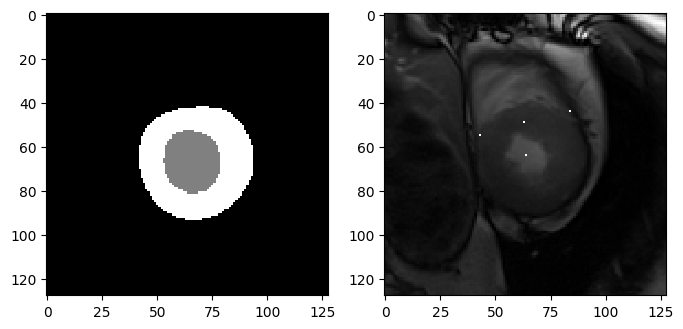

In [722]:
img_ed = nb.load(os.path.join(patient_img_folder, 'img_tf' + str(tf1) + '.nii.gz')).get_fdata()

# define mid slice
mid_slice = effective_slices[len(effective_slices)//2]
print('mid_slice: ', mid_slice)

# define the RV insertion point
plt.figure(figsize=(8,4))
plt.subplot(121); plt.imshow(strain.mask[:,:,mid_slice], cmap='gray')
if 1==0:#os.path.isfile(os.path.join(save_folder, 'insertion_points.npy')):
    print('use saved')
    insertion_points = np.load(os.path.join(save_folder, 'insertion_points.npy'))
    insertion_p1 = insertion_points[0,:]
    insertion_p2 = insertion_points[1,:]
else:
    print('no there should be pre-defined insertion points!')
    # from the figure, we define the RV insertion points
    insertion_p1 = [44,84]
    insertion_p2 = [55,43]
    # make insertion_p1 and p2 as a 2x2 numpy array
    insertion_points = np.vstack((np.asarray(insertion_p1), np.asarray(insertion_p2)))
    # # save the insertion points
    np.save(os.path.join(save_folder, 'insertion_points.npy'), insertion_points)

# get the rotation angle ready
phi_angle   , cx_lv, cy_lv, cx_rv, cy_rv  = myocardial_strain_zc._get_lv2rv_angle_using_insertion_points(strain.mask, insertion_p1, insertion_p2)
print('phi_angle: ', phi_angle)

# plot
ii = np.copy(img_ed[:,:,mid_slice])
ii[insertion_p1[0], insertion_p1[1]] = np.max(ii); ii[insertion_p2[0], insertion_p2[1]] = np.max(ii)
ii[int(cx_lv), int(cy_lv)] = np.max(ii); ii[int(cx_rv), int(cy_rv)] = np.max(ii)
plt.subplot(122); plt.imshow(ii, cmap='gray')


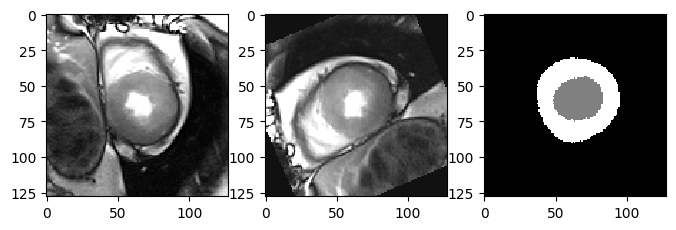

In [723]:
# rotate the data so that RV is under LV
rotate_f = myocardial_strain_zc.Rotate_data(strain.Err, strain.Ecc, strain.mask,img_ed, insertion_p1, insertion_p2 )
Err_rot, Ecc_rot, mask_rot, img_rot= rotate_f.rotate_orientation(for_visualization=False)

plt.figure(figsize=(8,4))
plt.subplot(131); plt.imshow(ff.set_window(img_ed[:,:,mid_slice],100,250), cmap='gray')
plt.subplot(132); plt.imshow(ff.set_window(img_rot[:,:,mid_slice], 100,250),cmap='gray')
plt.subplot(133); plt.imshow(mask_rot[:,:,5], cmap='gray')



In [15]:
# only keep the effective slices
Err_rot = Err_rot[:,:,effective_slices]
Ecc_rot = Ecc_rot[:,:,effective_slices]
mask_rot = mask_rot[:,:,effective_slices]
img_rot = img_rot[:,:,effective_slices]

# Step 5: Strain calculation and Polar Sampling

In [17]:
polar = myocardial_strain_zc.PolarMap(Err_rot, Ecc_rot, mask_rot)
polar_strain_result = polar.project_to_aha_polar_map()
# Ecc_polar, Ecc_aha = polar.construct_AHA_map(polar_strain_result['V_ecc'], start_slice_name = start_slice_name, start = 20, stop = 80) 
# # Ecc_aha first element is the mean for all AHA segments, followed by 16 segments + 1 apex (Set to 0)
# Err_polar, Err_aha = polar.construct_AHA_map(polar_strain_result['V_err'], start_slice_name = start_slice_name, start = 20, stop = 80)

... radial strain
... circumferential strain


In [20]:
Ecc_polar, Ecc_aha = polar.construct_AHA_map(polar_strain_result['V_ecc'], start_slice_name = 'base', start = 20, stop = 80) 
# Ecc_aha first element is the mean for all AHA segments, followed by 16 segments + 1 apex (Set to 0)
Err_polar, Err_aha = polar.construct_AHA_map(polar_strain_result['V_err'], start_slice_name = 'base', start = 20, stop = 80)

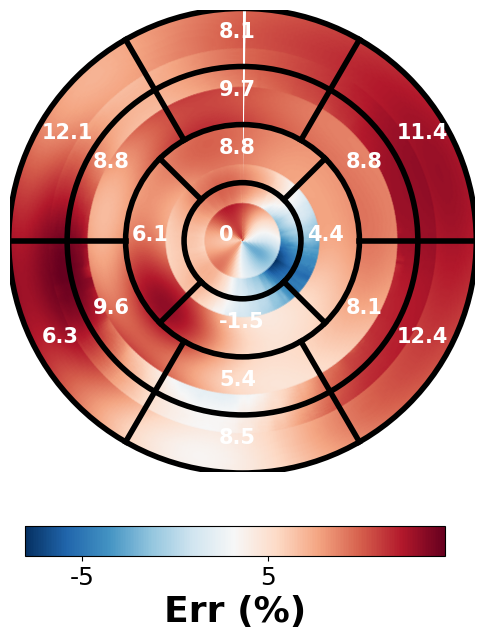

In [21]:
myocardial_strain_zc.plot_bullseye(Err_polar,Err_aha[1:],vmin=None,vmax=None, savepath=None,cmap='RdBu_r', label='Err (%)', 
                  std=None,cbar=True,color='white', fs=15, xshift=0, yshift=0, ptype='mesh',frac=False)

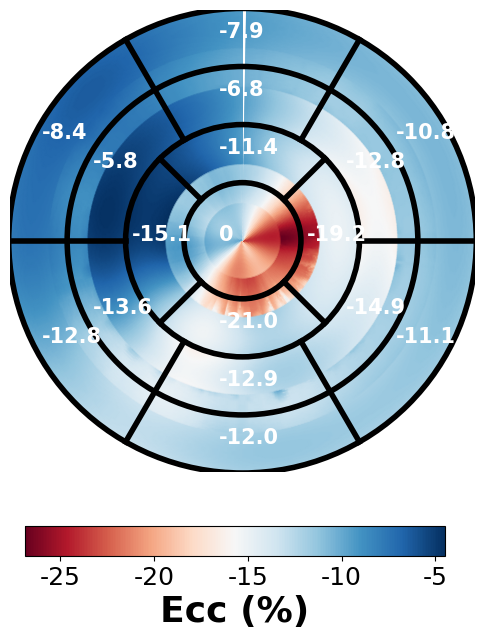

In [22]:
myocardial_strain_zc.plot_bullseye(Ecc_polar,Ecc_aha[1:],vmin=None,vmax=None, savepath=None,cmap='RdBu', label='Ecc (%)', 
                  std=None,cbar=True,color='white', fs=15, xshift=0, yshift=0, ptype='mesh',frac=False)

# Step 6: calculate wall thickness change index and polar sampling

In [44]:
# # find out which slices need to use wall thickness change index
# need_recal_slice_num = []
# for j in range(strain.Err.shape[-1]):
#     a = strain.Err[:,:,j]
#     a = a[strain.mask_rot[:,:,j]==2] * 100
#     if np.mean(a)<1:
#         print('this slice needs to use segmentation of Err: ', j)
#         need_recal_slice_num.append(j)

# # find out the index of j in ID:
# need_recal_slice_index = [ID.index(uu)  if uu in ID else None for uu in need_recal_slice_num]
# print(need_recal_slice_index)

In [77]:
# wall_thickness = myocardial_strain_zc.wall_thickness_change_index(mask_rot, mask_rot_es)
# wtci = wall_thickness.calculate_index()
# wtci_polar, wtci_aha = wall_thickness.construct_AHA_map(wtci, start_slice_name = start_slice_name)

In [45]:
# myocardial_strain_zc.plot_bullseye(wtci_polar, wtci_aha[1:],vmin=None,vmax=None, savepath=None,cmap='RdBu_r', label='WTCI (%)', 
#                   std=None,cbar=True,color='white', fs=15, xshift=0, yshift=0, ptype='mesh',frac=False)

# collect all the parameters and save into numpy

In [25]:
raw_strain = [strain]
slice_info = [effective_slices, 'base', base_layer, mid_layer, apex_layer]
global_strain =   [global_radial_strain, global_circumferential_strain]
layer_strain = [  layer_radial_strain, layer_circumferential_strain]
# rotated_mask = [ mask_rot, mask_rot_es,  mask_rot_vis]
polar_strain = [ Ecc_aha[1:],Err_aha[1:]]
# wtci_collect = [need_recal_slice_num, need_recal_slice_index, wtci, wtci_polar, wtci_aha[1:]]

# save all above
np.save(os.path.join(save_folder, 'raw_strain.npy'), np.asarray(raw_strain))
np.save(os.path.join(save_folder, 'slice_info.npy'), np.asarray(slice_info))
np.save(os.path.join(save_folder, 'global_strain.npy'), np.asarray(global_strain))
np.save(os.path.join(save_folder, 'layer_strain.npy'), np.asarray(layer_strain))
# np.save(os.path.join(save_folder, 'rotated_mask.npy'), np.asarray(rotated_mask))
np.save(os.path.join(save_folder, 'polar_strain.npy'), np.asarray(polar_strain))
# np.save(os.path.join(save_folder, 'wtci.npy'), np.asarray(wtci_collect))

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


# Repeat the process for other time frames

In [2]:
# find patinet_list
patient_list = spreadsheet.iloc[0:50]
patient_index = 0

In [4]:
# first: get the ED and ES frame
patient_id_num = patient_list['OurID'].iloc[patient_index]
patient_id = ff.XX_to_ID_00XX(patient_id_num)
patient_row = spreadsheet.loc[spreadsheet['OurID'] == patient_id_num]
ED = patient_row['ED'].values[0].astype(int)
ES = patient_row['ES'].values[0].astype(int)
print(patient_id, ED,ES)

for k in range(3,4):#25):
    if ED + k == 25:
        tf = 25
    else:
        tf = (ED + k)%25

    print('now working on time frame: ', tf)

    save_folder = os.path.join(main_path, 'results/strain/', patient_id, 'per_time_frame', 'ED + ' + str(k))
    ff.make_folder([save_folder])

    # first: let's repeat strain
    patient_img_folder = os.path.join(data_path, 'nii_img', patient_id)
    patient_seg_folder1 = os.path.join(data_path, 'nii_manual_seg', patient_id)
    patient_seg_folder2 =os.path.join(main_path,'results/fine_tune_carson/seg/')

    V_nifti_ED = nb.load(os.path.join(patient_img_folder, 'Org3D_frame' + str(ED) + '.nii.gz'))
    V_nifti_tf = nb.load(os.path.join(patient_img_folder, 'Org3D_frame' + str(tf) + '.nii.gz'))

    M_nifti_ED = nb.load(os.path.join(patient_seg_folder1, 'SAX_ED_seg.nii.gz'))

    if tf == ES and os.path.isfile(os.path.join(patient_seg_folder1, 'SAX_ES_seg.nii.gz')) == True:
        M_nifti_tf = nb.load(os.path.join(patient_seg_folder1, 'SAX_ES_seg.nii.gz'))
    elif tf == ED and os.path.isfile(os.path.join(patient_seg_folder1, 'SAX_ED_seg.nii.gz')) == True:
        M_nifti_tf = nb.load(os.path.join(patient_seg_folder1, 'SAX_ED_seg.nii.gz'))
    else:
        print('use this')
        M_nifti_tf = nb.load(os.path.join(patient_seg_folder2, patient_id,'pred_seg_frame' + str(tf) + '.nii.gz'))
    
    # make affine consistent (Although the manual one and the predicted one should be consistent but in fact they have difference in demicals)
    M_nifti_tf = nb.Nifti1Image(M_nifti_tf.get_fdata(), affine=M_nifti_ED.affine, header=M_nifti_ED.header)

    M_nifti_ED_RV = nb.load(os.path.join(main_path,'results/fine_tune_carson/seg/' ,patient_id,'pred_seg_frame' + str(ED) + '.nii.gz'))
    M_nifti_tf_RV = nb.load(os.path.join(main_path,'results/fine_tune_carson/seg/' ,patient_id,'pred_seg_frame' + str(tf) + '.nii.gz'))

    M_ED = np.round(M_nifti_ED.get_fdata()).astype(int)
    M_ED_RV = np.round(M_nifti_ED_RV.get_fdata()).astype(int)
    new_M_ED = np.zeros_like(M_ED)
    new_M_ED[M_ED_RV==3] = 1
    new_M_ED[M_ED==1] = 3
    new_M_ED[M_ED==2] = 2
    M_nifti_ED = nb.Nifti1Image(new_M_ED, affine=M_nifti_ED.affine, header=M_nifti_ED.header)

    M_tf = np.round(M_nifti_tf.get_fdata()).astype(int)
    M_tf_RV = np.round(M_nifti_tf_RV.get_fdata()).astype(int)
    new_M_tf = np.zeros_like(M_tf)
    new_M_tf[M_tf_RV==3] = 1
    new_M_tf[M_tf==1] = 3
    new_M_tf[M_tf==2] = 2
    M_nifti_tf = nb.Nifti1Image(new_M_tf, affine=M_nifti_tf.affine, header=M_nifti_tf.header)

    V_nifti = nb.funcs.concat_images((V_nifti_ED, V_nifti_tf))
    M_nifti = nb.funcs.concat_images((M_nifti_ED, M_nifti_tf))

    V_nifti = resample_nifti(V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=16)
    M_nifti = resample_nifti(M_nifti, order=0, in_plane_resolution_mm=1.25, number_of_slices=16)

    center = center_of_mass(M_nifti.get_fdata()[:,:,:,0]==2)
    V = _roll2center_crop(x=V_nifti.get_fdata(), center=center)
    M = _roll2center_crop(x=M_nifti.get_fdata(), center=center)

    V = ff.normalize_image(V)
    nx, ny, nz, nt = V.shape
    V_0 =  np.repeat(V[:,:,:,:1], nt-1, axis=-1)
    V_t =  V[:,:,:,1:]

    V_0 = np.transpose(V_0, (3,0,1,2))
    V_t = np.transpose(V_t, (3,0,1,2))

    mvf_file = os.path.join(main_path, 'results/trained/mvf', patient_id, 'mvf_ED' + str(ED) + '_tf' + str(tf) + '.nii.gz')
    print('mvf_file: ', mvf_file)
    y_t = nb.load(mvf_file).get_fdata()
    y_t = y_t[None,...]
    
    mask_end_diastole = M[..., 0]
    mask_tf = M[..., 1]

    # calculate strain
    strain = myocardial_strain_zc.MyocardialStrain(mask=mask_end_diastole, flow=y_t[0,:,:,:,:])
    strain.calculate_strain(lv_label=2)
    strain_tf = myocardial_strain_zc.MyocardialStrain(mask=mask_tf, flow=y_t[0,:,:,:,:])
    strain_tf.calculate_strain(lv_label=2)

    global_radial_strain = strain.Err[strain.mask_rot==2].mean()
    global_circumferential_strain = strain.Ecc[strain.mask_rot==2].mean()

    # second: slice info (this can be loaded from ED ES experiment)
    slice_info = np.load(os.path.join(main_path, 'results/strain/', patient_id, 'slice_info.npy'), allow_pickle=True)
    slice_effective, slice_nonzero_ed, slice_nonzero_tf, start_slice_name, base_layer, mid_layer, apex_layer = slice_info
    print('slice_effective: ', slice_effective)
    print('slice_nonzero_ed: ', slice_nonzero_ed)
    print('slice_nonzero_tf: ', slice_nonzero_tf)

    # slice_nonzero_ed = [i for i in range(strain.mask.shape[2]) if np.sum(strain.mask[:,:,i] > 1)>0]
    # slice_nonzero_tf = [i for i in range(strain_tf.mask.shape[2]) if np.sum(strain_tf.mask[:,:,i] > 1)>0]
    # # find the effective slices, which is the intersection of nonzero slices in ED and ES. please write the code here
    # slice_effective = []
    # for i in slice_nonzero_ed:
    #     if i in slice_nonzero_tf:
    #         slice_effective.append(i)
    # print(strain.mask.shape, slice_nonzero_ed)
    # print(strain_tf.mask.shape, slice_nonzero_tf)
    # print('slice Effective: ', slice_effective)

    # third: layer strain
    Err_copy = np.copy(strain.Err)
    Err_layer = []
    for l in range(0,len([base_layer, mid_layer,apex_layer])):
        layer = [base_layer, mid_layer,apex_layer][l]

        err_copy = np.copy(Err_copy[:,:,layer])
    
        Err_layer.append(err_copy[strain.mask_rot[:,:,layer]==2].mean())

    Ecc_copy = np.copy(strain.Ecc)
    Ecc_layer = []
    for l in range(0,len([base_layer, mid_layer,apex_layer])):
        layer = [base_layer, mid_layer,apex_layer][l]
    
        ecc_copy = np.copy(Ecc_copy[:,:,layer])
    
        Ecc_layer.append(ecc_copy[strain.mask_rot[:,:,layer]==2].mean())

    layer_radial_strain = np.asarray(Err_layer)
    layer_circumferential_strain = np.asarray(Ecc_layer)

    # fourth: rotate data
    if os.path.isfile(os.path.join(main_path, 'results/strain/', patient_id, 'insertion_points.npy')):
        insertion_points = np.load(os.path.join(main_path, 'results/strain/', patient_id, 'insertion_points.npy'))
        insertion_p1 = insertion_points[0,:]
        insertion_p2 = insertion_points[1,:]
    else:
       ValueError('no there should be pre-defined insertion points!')
    phi_angle   , cx_lv, cy_lv, cx_rv, cy_rv  = myocardial_strain_zc._get_lv2rv_angle_using_insertion_points(strain.mask, insertion_p1, insertion_p2)

    # rotate the data so that RV is under LV
    rotate_f = myocardial_strain_zc.Rotate_data(strain.Err, strain.Ecc, strain.mask, insertion_p1, insertion_p2, non_slice_num = slice_effective )
    Err_rot, Ecc_rot, mask_rot, ID = rotate_f.rotate_orientation(for_visualization=False)
    Err_rot_vis, Ecc_rot_vis, mask_rot_vis, ID = rotate_f.rotate_orientation(for_visualization=True)

    rotate_f_tf = myocardial_strain_zc.Rotate_data(strain.Err, strain.Ecc, strain_tf.mask, insertion_p1, insertion_p2, non_slice_num = slice_effective )
    _,_, mask_rot_tf, ID = rotate_f_tf.rotate_orientation(for_visualization=False)
  
    # fifth: polar strain
    polar = myocardial_strain_zc.PolarMap(Err_rot, Ecc_rot, mask_rot)
    polar_strain_result = polar.project_to_aha_polar_map()
    Ecc_polar, Ecc_aha = polar.construct_AHA_map(polar_strain_result['V_ecc'], start_slice_name = start_slice_name, start = 20, stop = 80) 
    Err_polar, Err_aha = polar.construct_AHA_map(polar_strain_result['V_err'], start_slice_name = start_slice_name, start = 20, stop = 80)
    
    # sixth: wtci
    wtci_previous_file = np.load(os.path.join(main_path, 'results/strain/', patient_id, 'wtci.npy'),allow_pickle = True)
    need_recal_slice_num, need_recal_slice_index, _,_,_ = wtci_previous_file

    wall_thickness = myocardial_strain_zc.wall_thickness_change_index(mask_rot, mask_rot_tf)
    wtci = wall_thickness.calculate_index()
    wtci_polar, wtci_aha = wall_thickness.construct_AHA_map(wtci, start_slice_name = start_slice_name)

    # seventh: collect and save
    raw_strain = [strain]
    slice_info = [slice_effective, slice_nonzero_ed, slice_nonzero_tf, start_slice_name, base_layer, mid_layer, apex_layer]
    global_strain =   [global_radial_strain, global_circumferential_strain]
    layer_strain = [  layer_radial_strain, layer_circumferential_strain]
    rotated_mask = [ mask_rot, mask_rot_tf,  mask_rot_vis]
    polar_strain = [Err_rot, Ecc_rot, Err_rot_vis, Ecc_rot_vis, Ecc_polar, Ecc_aha[1:], Err_polar, Err_aha[1:]]
    wtci_collect = [need_recal_slice_num, need_recal_slice_index, wtci, wtci_polar, wtci_aha[1:]]

    # save all above
    np.save(os.path.join(save_folder, 'raw_strain.npy'), np.asarray(raw_strain))
    np.save(os.path.join(save_folder, 'slice_info.npy'), np.asarray(slice_info))
    np.save(os.path.join(save_folder, 'global_strain.npy'), np.asarray(global_strain))
    np.save(os.path.join(save_folder, 'layer_strain.npy'), np.asarray(layer_strain))
    np.save(os.path.join(save_folder, 'rotated_mask.npy'), np.asarray(rotated_mask))
    np.save(os.path.join(save_folder, 'polar_strain.npy'), np.asarray(polar_strain))
    np.save(os.path.join(save_folder, 'wtci.npy'), np.asarray(wtci_collect))

    
    

ID_0692 1 8
now working on time frame:  4
use this
mvf_file:  /mnt/mount_zc_NAS/Deepstrain/results/trained/mvf/ID_0692/mvf_ED1_tf4.nii.gz
slice_effective:  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
slice_nonzero_ed:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
slice_nonzero_tf:  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
(128, 128, 16) [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
(128, 128, 16) [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
slice Effective:  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
dis.shape[0] == 0


IndexError: index 0 is out of bounds for axis 0 with size 0